<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/jupyter/baseic_EDFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of EDFA using a WDM signal

In [1]:
import numpy as np
import os.path as path
from scipy.constants import c

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.amplification import edfaSM, wdm_analyzer, edfa_analyzer, OSA

#import logging as logg
#logg.getLogger().setLevel(logg.INFO)
#logg.basicConfig(format='%(message)s')

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

## Parameters

In [4]:
# EDFA parameters
param_edfa = parameters()
param_edfa.type     = "AGC"
param_edfa.value    = 20 #dB
param_edfa.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.file     = 'giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 0.05
param_edfa.tolCtrl  = 0.5

In [5]:
if 'google.colab' in str(get_ipython()):  
  param_edfa.file = path.join(path.abspath(path.join("../")), 'OptiCommPy', 'optic', 'ampParams', param_edfa.file)
else:
  param_edfa.file = path.join(path.abspath(path.join("../")), 'optic', 'ampParams', param_edfa.file)

In [6]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 4             # order of the modulation format
paramTx.Rs  = 40e9          # symbol rate [baud]
paramTx.SpS = 256           # samples per symbol
paramTx.Nbits = 2**10       # total number of bits per polarization
paramTx.pulse = 'rrc'       # pulse shaping filter
paramTx.Ntaps = 1024        # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01     # RRC rolloff
paramTx.Pch_dBm = -15       # power per WDM channel [dBm]
paramTx.Nch     = 40        # number of WDM channels
paramTx.Fc      = c/1550e-9 # central optical frequency of the WDM spectrum
paramTx.freqSpac = 200e9    # WDM grid spacing
paramTx.Nmodes = 2          # number of signal modes [2 for polarization multiplexed signals]

## Simulation

**Signal generation**

In [7]:
# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
lenFrqSg,isy = np.shape(sigWDM_Tx)
Fs = paramTx.Rs*paramTx.SpS
simOpticalBand = (Fs*(c/paramTx.Fc)**2)/c

(-100.0, 0.0)

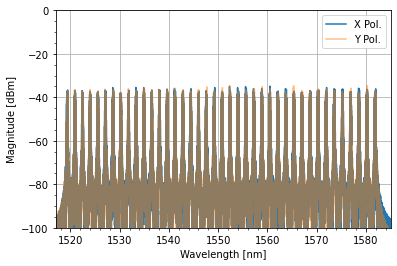

In [9]:
ax = OSA(sigWDM_Tx, Fs, paramTx.Fc)
ax.set_xlim([1517,1585])
ax.set_ylim([-100,0])

,Wav. [nm],Freq. [Thz],Spacing [THz],Power [dBm],Noise [dBm],OSNR [dB]
Channel,,,,,,
0,1581.911644,189.512770,200.546875,-47.133935,-94.028134,46.894199
1,1580.239397,189.713317,200.546875,-47.075262,-95.923361,48.848099
2,1578.567436,189.914255,200.937500,-46.993635,-93.900724,46.907090
3,1576.902896,190.114723,200.468750,-47.007996,-91.457975,44.449979
4,1575.252210,190.313942,199.218750,-47.405814,-90.408780,43.002966
5,1573.583036,190.515817,201.875000,-47.413376,-92.525054,45.111678
6,1571.934782,190.715583,199.765625,-47.146693,-95.110331,47.963638
7,1570.305399,190.913473,197.890625,-46.957351,-90.451642,43.494290
8,1568.666565,191.112927,199.453125,-47.059490,-90.342396,43.282906


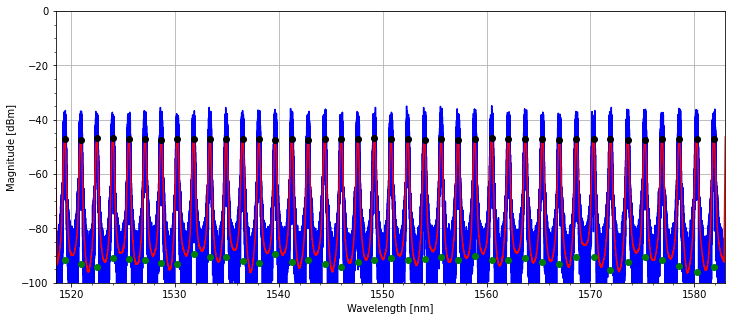

In [10]:
wdm_analyzer(sigWDM_Tx[:,0], Fs, paramTx.Fc, xlim = np.array([1518.5,1583]))

In [11]:
# information TX
pwrTx = 1000*np.sum(np.mean(sigWDM_Tx * np.conj(sigWDM_Tx), axis = 0).real)
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*lenFrqSg/Fs))
print('Central wavelength [nm]: %6.2f' %(1e9*c/paramTx.Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(c/paramTx.Fc-simOpticalBand/2), 1e9*(c/paramTx.Fc+simOpticalBand/2)))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/lenFrqSg))
print('Number of points: %d' %(lenFrqSg))
print('Number of modes: %d' %(paramTx.Nmodes))
print('Average power - TX [mW] : %.3f mW' %(pwrTx))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(pwrTx)))

Sample rate [THz]: 10.240
Time window [ns]:  12.800
Central wavelength [nm]: 1550.00
Simulation window  [nm]: 82.062104 - [1508.97 nm - 1591.03 nm]
Frequency spacing [GHz]: 0.078125
Number of points: 131072
Number of modes: 2
Average power - TX [mW] : 1.265 mW
Average power - TX [dBm] : 1.021 dBm


**Signal amplification**

In [12]:
#%load_ext line_profiler
#%lprun -f edfaSM edfaSM(sigWDM_Tx, Fs, paramTx.Fc, param_edfa)
# amplification
Eout, PumpF, PumpB = edfaSM(sigWDM_Tx, Fs, paramTx.Fc, param_edfa)

In [13]:
# information amp
rx_pw = 1000*np.sum(np.mean(Eout * np.conj(Eout), axis = 0).real)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/pwrTx)))

Forward pump  - [mW] : 222.460
Backward pump - [mW] : 0.000
Average power - RX amp [mW] : 114.871
Average power - RX amp [dBm] : 20.602
Gain [dB]: 19.582


(-100.0, 0.0)

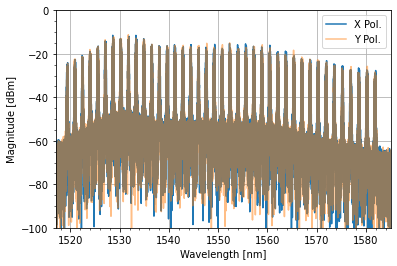

In [14]:
ax = OSA(Eout, Fs, paramTx.Fc)
ax.set_xlim([1517,1585])
ax.set_ylim([-100,0])

,Wav. [nm],Freq. [Thz],Spacing [THz],Power [dBm],Noise [dBm],OSNR [dB]
Channel,,,,,,
0,1581.911644,189.512770,200.546875,-38.695572,-74.525431,35.829859
1,1580.239397,189.713317,200.546875,-38.181349,-73.960743,35.779394
2,1578.567436,189.914255,200.937500,-37.609952,-73.216313,35.606361
3,1576.902896,190.114723,200.468750,-37.051585,-72.607345,35.555761
4,1575.252210,190.313942,199.218750,-36.772667,-71.712592,34.939924
5,1573.583036,190.515817,201.875000,-35.961091,-70.822819,34.861728
6,1571.934782,190.715583,199.765625,-34.813452,-70.115868,35.302416
7,1570.305399,190.913473,197.890625,-33.643044,-68.875812,35.232768
8,1568.666565,191.112927,199.453125,-32.745138,-67.838918,35.093780


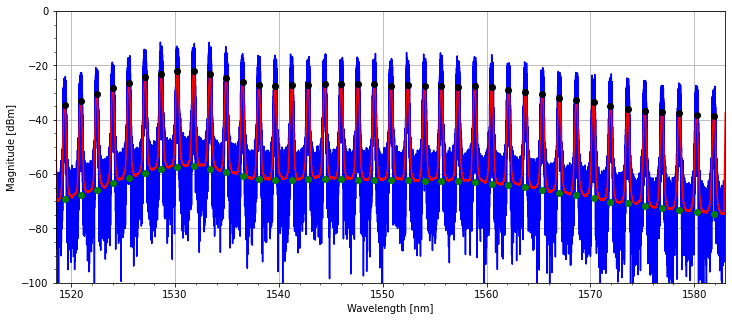

In [15]:
wdm_analyzer(Eout[:,0], Fs, paramTx.Fc, xlim = np.array([1518.5,1583]))

,Wav. [nm],Freq. [Thz],Gain [dB],Noise figure [dB]
Channel,,,,
0,1578.567436,189.914255,9.383683,5.394617
1,1576.902896,190.114723,9.956411,5.715393
2,1575.252210,190.313942,10.633147,6.289376
3,1573.583036,190.515817,11.452285,6.825465
4,1571.934782,190.715583,12.333241,7.185274
5,1570.305399,190.913473,13.314307,8.062807
6,1568.666565,191.112927,14.314352,8.760856
7,1566.994034,191.316911,15.377860,9.191601
8,1565.360185,191.516598,16.368933,10.058279


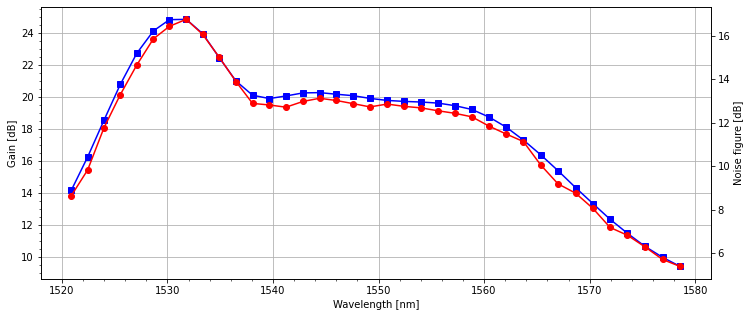

In [16]:
edfa_analyzer(sigWDM_Tx[:,0], Eout[:,0], Fs, paramTx.Fc)